<a href="https://colab.research.google.com/github/AnishNoel24/Mini-Project-44-UNet-for-Image-Segmentation/blob/main/Mini_Project_44_UNet_for_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-mooxc8ue
  Running command git clone --filter=blob:none --quiet https://github.com/jakeret/unet.git /tmp/pip-req-build-mooxc8ue
  Resolved https://github.com/jakeret/unet.git to commit f557a51b6f95aae6848cab6141e6cae573934bf8
  Preparing metadata (setup.py) ... done
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25688 sha256=40163c0eb46749e8c47c4a275ae3b4900230b37cead7ef6966d5ae6c823cad56
  Stored in directory: /tmp/pip-ephem-wheel-cache-e2hj5eni/wheels/56/24/6c/b2b189a63368c1ab66b932b07451b6fcc2a7b50724f5ec4cb5
Successfully built unet


In [2]:
%load_ext tensorboard
import unet
from unet.datasets import oxford_iiit_pet
from tensorflow.keras import losses, metrics

In [3]:
from typing import Optional, Union, Callable, List

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam

import unet.metrics
def finalize_model(model: Model,
                   loss: Optional[Union[Callable, str]]=losses.categorical_crossentropy,
                   optimizer: Optional= None,
                   metrics:Optional[List[Union[Callable,str]]]=None,
                   dice_coefficient: bool=True,
                   auc: bool=True,
                   mean_iou: bool=True,
                   **opt_kwargs):
    """
    Configures the model for training by setting, loss, optimzer, and tracked metrics
    :param model: the model to compile
    :param loss: the loss to be optimized. Defaults to `categorical_crossentropy`
    :param optimizer: the optimizer to use. Defaults to `Adam`
    :param metrics: List of metrics to track. Is extended by `crossentropy` and `accuracy`
    :param dice_coefficient: Flag if the dice coefficient metric should be tracked
    :param auc: Flag if the area under the curve metric should be tracked
    :param mean_iou: Flag if the mean over intersection over union metric should be tracked
    :param opt_kwargs: key word arguments passed to default optimizer (Adam), e.g. learning rate
    """

    if optimizer is None:
        optimizer = Adam(**opt_kwargs)

    if metrics is None:
        metrics = ['categorical_crossentropy',
                   'categorical_accuracy',
                   ]

    if mean_iou:
        metrics += [unet.metrics.mean_iou]

    if dice_coefficient:
        metrics += [unet.metrics.dice_coefficient]

    if auc:
        metrics += [tf.keras.metrics.AUC()]

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics,
                  jit_compile=True
                  )

In [4]:
LEARNING_RATE = 1e-3
unet_model = unet.build_model(*oxford_iiit_pet.IMAGE_SIZE,
                              channels=oxford_iiit_pet.channels,
                              num_classes=oxford_iiit_pet.classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same"
                              )

finalize_model(unet_model,
                    loss=losses.SparseCategoricalCrossentropy(),
                    metrics=[metrics.SparseCategoricalAccuracy()],
                    auc=False,
                    learning_rate=LEARNING_RATE)


In [5]:
train_dataset, validation_dataset = oxford_iiit_pet.load_data()

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
%tensorboard --logdir oxford_iiit_pet

<IPython.core.display.Javascript object>

In [7]:
trainer = unet.Trainer(name="oxford_iiit_pet", checkpoint_callback=False)
trainer.fit(unet_model,
            train_dataset,
            validation_dataset,
            epochs=25,
            batch_size=32)

1/1 [==============================] - 16s 16s/step
Epoch 1/25
  6/115 [>.............................] - ETA: 42s - loss: 1.6986 - sparse_categorical_accuracy: 0.4737 - mean_iou: 0.3010 - dice_coefficient: 0.8788

115/115 [==============================] - 136s 758ms/step - loss: 0.9997 - sparse_categorical_accuracy: 0.5605 - mean_iou: 0.3029 - dice_coefficient: 0.8890 - val_loss: 0.8820 - val_sparse_categorical_accuracy: 0.5731 - val_mean_iou: 0.3012 - val_dice_coefficient: 0.8931 - learning_rate: 0.0010
Epoch 2/25
115/115 [==============================] - 65s 569ms/step - loss: 0.8075 - sparse_categorical_accuracy: 0.6386 - mean_iou: 0.3029 - dice_coefficient: 0.8890 - val_loss: 0.7781 - val_sparse_categorical_accuracy: 0.6014 - val_mean_iou: 0.3003 - val_dice_coefficient: 0.8931 - learning_rate: 0.0010
Epoch 3/25
115/115 [==============================] - 65s 570ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.7169 - mean_iou: 0.3069 - dice_coefficient: 0.8890 - val_loss: 0.6832 - val_sparse_categorical_accuracy: 0.7125 - val_mean_iou: 0.3048 - val_dice_coefficient: 0.8931 - learning_rate: 0.0010
Epoch 4/25
115/115 [==============================] - 65s 570ms/step - loss: 0.6373 - spa

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 27ms/step


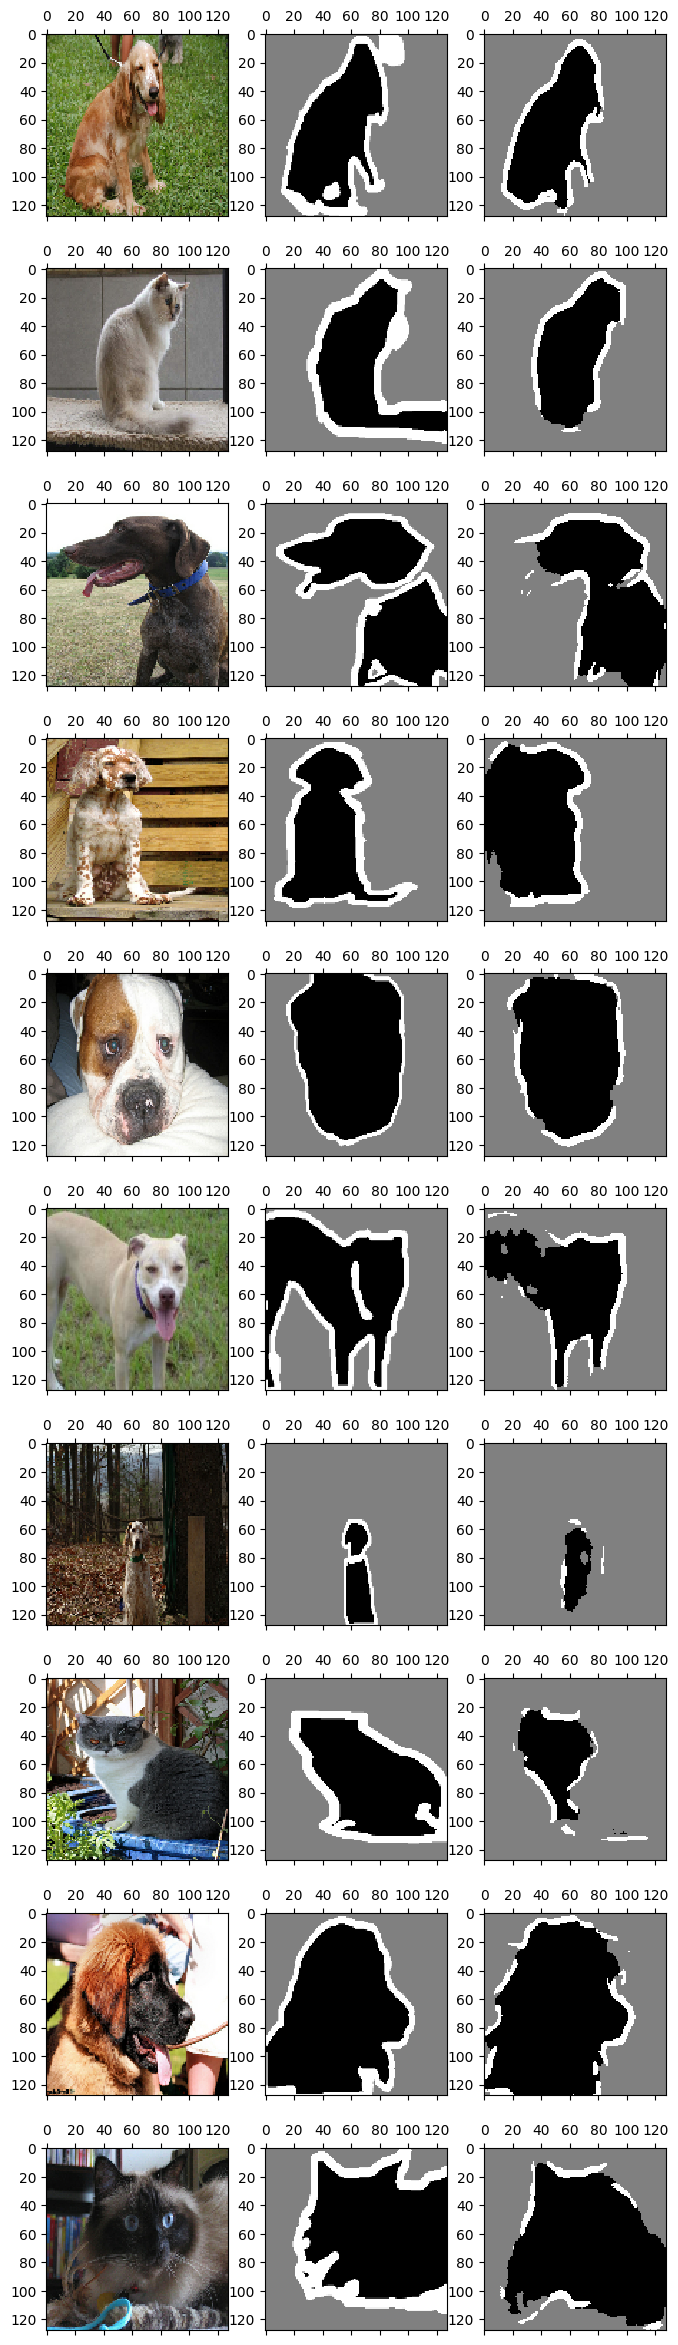

In [9]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, train_dataset.take(rows).batch(1)):

  prediction = unet_model.predict(image)
  ax[0].matshow(image[0])
  ax[1].matshow(label[0, ..., 0], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")